In [31]:
import brainiak.eventseg.event as event
from tqdm.notebook import tqdm
from scipy.stats import wasserstein_distance, pearsonr
import matplotlib.patches as patches


In [32]:
import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from scipy.stats import rankdata

from sentence_transformers import SentenceTransformer
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model_USE = hub.load(module_url)

from sklearn.metrics.pairwise import cosine_similarity


def embed(input):
    return model_USE(input)

def run_and_plot_modified_USE(messages_,ML_lab,title,plot):
    message_embeddings_ = embed(messages_)
    if plot == True:
        plot_similarity_modified(ML_lab, message_embeddings_, 90,title)
    return message_embeddings_


def plot_similarity_modified(labels, features, rotation,title):
    corr = cosine_similarity(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
        #annot=True,
        #annot_kws={"fontsize":10},
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title='USE Sentence by Sentence'

    #g.set_title(title, fontsize=18)
    plt.gcf().subplots_adjust(bottom=0.15)    
    return corr
def run_and_plot_modified_USE(messages_,ML_lab,title,plot):
    message_embeddings_ = embed(messages_)
    if plot == True:
        corr = plot_similarity_modified(ML_lab, message_embeddings_, 90,title)
    return message_embeddings_, corr


In [5]:
text_dir = '../paranoia_text/'

f = open(text_dir + 'stimuli_story_fulltext.txt',"r")
#print(f.read())
f = str(f.read())
idx_start = str.find(f,'The email')
f = f[idx_start:]


In [6]:
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"
digits = "([0-9])"
def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    if "..." in text: text = text.replace("...","<prd><prd><prd>")
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [103]:
#sentences = split_into_sentences(f)
df = pd.read_csv('../paranoia_text/sentence_labels_2.csv')
df.head()
sentences = list(df['sentence'])


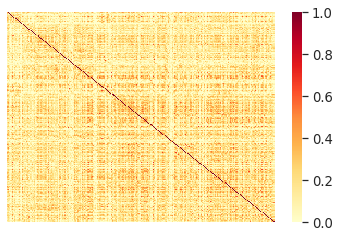

In [104]:
embeddings,corrmat = run_and_plot_modified_USE(sentences,[],title='USE-sentence structure',plot=True)


### doing overlapping chunks

In [105]:
def combine_sentence(sentences_new):
    a = ""
    for s in sentences_new: 
        a = a + s
    return a

In [114]:
# n = 8  # group size
# m = 6  # overlap size
# sentences_new = [combine_sentence(sentences[i:i+n]) for i in range(0, len(sentences), n-m)]

n = 6  # group size
m = 4  # overlap size
sentences_new = [combine_sentence(sentences[i:i+n]) for i in range(0, len(sentences), n-m)]


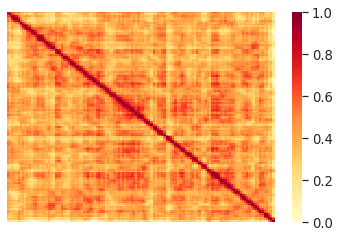

In [115]:
embeddings,corrmat = run_and_plot_modified_USE(sentences_new,[],title='USE-sentence structure',plot=True)


#### We feed the embeddings to the HMM model
code inspired by : https://github.com/ContextLab/sherlock-topic-model-paper

In [18]:
def create_diag_mask(arr, diag_start=0, diag_limit=None):
    diag_mask = np.zeros_like(arr, dtype=bool)
    if diag_limit is None:
        diag_limit = find_diag_limit(arr)

    for k in range(diag_start, diag_limit):
        ix = kth_diag_indices(diag_mask, k)
        diag_mask[ix] = True

    return diag_mask
def kth_diag_indices(arr, k):
    row_ix, col_ix = np.diag_indices_from(arr)
    if k == 0:
        return row_ix, col_ix
    else:
        return row_ix[:-k], col_ix[k:]
def find_diag_limit(arr):
    for k in range(arr.shape[0]):
        d = np.diag(arr, k=k)
        if ~(d > 0).any():
            return k
def reduce_model(m, ev):
    """Reduce a model based on event labels"""
    w = (np.round(ev.segments_[0]) == 1).astype(bool)
    return np.array([m[wi, :].mean(axis=0) for wi in w.T])

In [19]:
n_events = np.arange(2, 30)
wd = np.zeros(len(n_events))


for i, events in enumerate(tqdm(n_events, leave=False)):
    ev = event.EventSegment(events)
    try:
        ev.fit(embeddings.numpy())
    except:
        #if not tensor
        ev.fit(embeddings)
    i1, i2 = np.where(np.round(ev.segments_[0]) == 1)
    w = np.zeros_like(ev.segments_[0])
    w[i1, i2] = 1
    mask = np.dot(w, w.T).astype(bool)

    # Create mask such that the maximum temporal distance 
    # for within and across correlations is the same
    local_mask = create_diag_mask(mask)
    
    within_vals = np.reshape(corrmat[mask*local_mask], -1) 
    across_vals = np.reshape(corrmat[~mask*local_mask], -1)
    wd[i] = wasserstein_distance(within_vals, across_vals)

  0%|          | 0/28 [00:00<?, ?it/s]

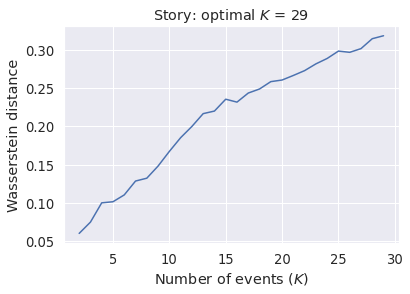

In [20]:
#plotting the Wasserstein distance

plt.plot(n_events, wd)
maxk_video = n_events[np.argmax(wd)]
plt.ylabel('Wasserstein distance')
plt.xlabel('Number of events ($K$)')
plt.title(f'Story: optimal $K$ = {maxk_video}')
# plt.savefig(FIG_DIR.joinpath('k_optimization_video.pdf'), bbox_inches='tight')
plt.show()

In [21]:
#fitting the model to get the events from the story
ev = event.EventSegment(maxk_video)
ev.fit(embeddings.numpy())
story_events = reduce_model(embeddings.numpy(), ev)

#### Setting the number of events manually

In [119]:
#fitting the model to get the events from the story

ev = event.EventSegment(12)
ev.fit(embeddings.numpy())
story_events = reduce_model(embeddings.numpy(), ev)

### Plotting 

In [126]:
def draw_bounds(ax, model):
    bounds = np.where(np.diff(np.argmax(model.segments_[0], axis=1)))[0]
    bounds_aug = np.concatenate(([0], bounds, [model.segments_[0].shape[0]]))
    print(bounds_aug)
    for i in range(len(bounds_aug) - 1):
        rect = patches.Rectangle((bounds_aug[i], bounds_aug[i]),
                                 bounds_aug[i + 1] - bounds_aug[i],
                                 bounds_aug[i + 1] - bounds_aug[i],
                                 linewidth=4,
                                 edgecolor=EDGECOLOR,
                                 facecolor='none')
        ax.add_patch(rect)

    return ax,bounds


[  0   8  21  33  42  52  63  72  81  91 103 115 123]


AttributeError: 'AxesSubplot' object has no attribute 'color_bar'

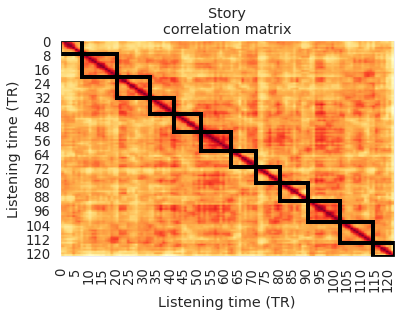

In [128]:
fig, ax = plt.subplots()

cmap = "YlOrRd"
EDGECOLOR='black'
sns.heatmap(corrmat, 
            vmin=0, 
            vmax=1, 
            cmap=cmap, 
            cbar=False, 
            ax=ax)
ax.set_title('Story\ncorrelation matrix')
ax.set_ylabel('Listening time (TR)')
ax.set_xlabel('Listening time (TR)')
for spine in ax.spines.values():
    spine.set_visible(True)


ax,bounds = draw_bounds(ax, ev)
ax.collections[0].remove()
ax.imshow(corrmat, aspect='auto', cmap=cmap)

In [121]:
np.save(f'USE_analysis_boundaries_nevents_{maxk_video}.npy',bounds)
np.save(f'USE_analysis_matrix.npy',corrmat)


### want to extend these to get the same length of time as TRs

In [33]:
df = pd.read_csv('../paranoia_text/sentence_labels.csv')
df.head()

,Unnamed: 0,run,sentence,sentence_offset_runsconcatenated,sentence_offset_inrun,mentalizing_event,sentiment
0,0,story1,The email came late one afternoon as Dr Carmen...,11,11,0,0.000000
1,1,story1,It had been a long day at the busy clinic in C...,18,18,0,-0.083333
2,2,story1,But the email’s strange subject line caught he...,23,23,0,-0.111111
3,3,story1,"“Fellow doctor, I need your help.”",26,26,1,0.333333
4,4,story1,It was sent by someone named Dr John Torreson.,29,29,0,0.000000


In [93]:
df['sentence'][0]

'The email came late one afternoon as Dr Carmen Reed was sitting in her office, filling out medical charts for the patients she had seen that day.'

In [42]:
T1 = 526
T2 = 452
T3 = 332

In [ ]:
i = 0
ment_r1 = np.zeros(T1)
ment_r2 = np.zeros(T2)
ment_r3 = np.zeros(T3)
sent_label_df = df
sent_label_df_r1 = sent_label_df[sent_label_df['run']=='story1'].reset_index()
sent_label_df_r2 = sent_label_df[sent_label_df['run']=='story2'].reset_index()
sent_label_df_r3 = sent_label_df[sent_label_df['run']=='story3'].reset_index()
i = 0
sent_label_df_r1['sentence_offset_inrun']
ment_r1 = np.zeros(T1)
ment_r2 = np.zeros(T2)
ment_r3 = np.zeros(T3)

In [49]:
df

,Unnamed: 0,run,sentence,sentence_offset_runsconcatenated,sentence_offset_inrun,mentalizing_event,sentiment
0,0,story1,The email came late one afternoon as Dr Carmen...,11,11,0,0.000000
1,1,story1,It had been a long day at the busy clinic in C...,18,18,0,-0.083333
2,2,story1,But the email’s strange subject line caught he...,23,23,0,-0.111111
3,3,story1,"“Fellow doctor, I need your help.”",26,26,1,0.333333
4,4,story1,It was sent by someone named Dr John Torreson.,29,29,0,0.000000
...,...,...,...,...,...,...,...
241,241,story3,But another part of her felt wracked with guil...,1289,311,0,-0.150000
242,242,story3,"Carmen pictured Alba’s wide, trusting eyes;",1293,315,0,0.000000
243,243,story3,"If she left now, the decision would haunt her ...",1297,319,0,-0.076923
244,244,story3,"On the other hand, she wasn’t even sure if the...",1305,327,0,-0.041667


In [75]:
length = (df['sentence_offset_runsconcatenated'][j]-df['sentence_offset_runsconcatenated'][j-1])
sentence = df['sentence'][j]

a = []
for i in range(length):
    a.append(sentence)
a

['What was she going to do?', 'What was she going to do?']

In [73]:
def concat_list(length, sentence):
    a = []
    for i in range(length):
        a.append(sentence)
    return a

should be 0 0


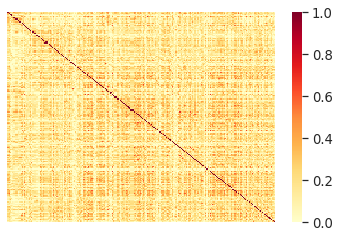

In [84]:
extended_sentence_list = []
for j in range(df.shape[0]):
    try:
        
        #extended_sentence_list.append([df['sentence'][j]]*(df['sentence_offset_runsconcatenated'][j]-df['sentence_offset_runsconcatenated'][j-1]))
        length = (df['sentence_offset_runsconcatenated'][j]-df['sentence_offset_runsconcatenated'][j-1])
        sentence = df['sentence'][j]
        a = concat_list(length,sentence)
        extended_sentence_list = extended_sentence_list + a 
    except:
        print('should be 0', j)
        length = (df['sentence_offset_runsconcatenated'][j])
        sentence = df['sentence'][j]
        a = concat_list(length,sentence)
        extended_sentence_list = extended_sentence_list + a 
                
len(extended_sentence_list)
embeddings,corrmat = run_and_plot_modified_USE(extended_sentence_list,[],title='USE-sentence structure',plot=True)


In [95]:
from scipy.interpolate import interp1d

In [94]:
len(extended_sentence_list)

1307

In [89]:
n_events = np.arange(5, 50)
wd = np.zeros(len(n_events))


for i, events in enumerate(tqdm(n_events, leave=False)):
    ev = event.EventSegment(events)
    try:
        ev.fit(embeddings.numpy())
    except:
        #if not tensor
        ev.fit(embeddings)
    i1, i2 = np.where(np.round(ev.segments_[0]) == 1)
    w = np.zeros_like(ev.segments_[0])
    w[i1, i2] = 1
    mask = np.dot(w, w.T).astype(bool)

    # Create mask such that the maximum temporal distance 
    # for within and across correlations is the same
    local_mask = create_diag_mask(mask)
    
    within_vals = np.reshape(corrmat[mask*local_mask], -1) 
    across_vals = np.reshape(corrmat[~mask*local_mask], -1)
    wd[i] = wasserstein_distance(within_vals, across_vals)

  0%|          | 0/45 [00:00<?, ?it/s]

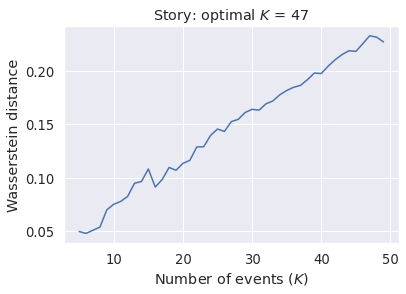

In [90]:
#plotting the Wasserstein distance

plt.plot(n_events, wd)
maxk_video = n_events[np.argmax(wd)]
plt.ylabel('Wasserstein distance')
plt.xlabel('Number of events ($K$)')
plt.title(f'Story: optimal $K$ = {maxk_video}')
# plt.savefig(FIG_DIR.joinpath('k_optimization_video.pdf'), bbox_inches='tight')
plt.show()

In [91]:
#fitting the model to get the events from the story

ev = event.EventSegment(12)
ev.fit(embeddings.numpy())
story_events = reduce_model(embeddings.numpy(), ev)